# W207 Final Project
Erika, Jen Jen, Geoff, Leslie

(In Python 3)

As of 3/35

Outline:

* Data Pre-Processing  
* Simple Feature Selection
* Basline Models
* Possible Approaches
   

# Section 1 Loading and Processing Data

In [1]:
# Import Libraries #
import json
from pprint import pprint
from pandas import *
from pandas.io.json import json_normalize

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# General libraries
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

# SK-learn libraries for pre/processing data
from sklearn import preprocessing

from sklearn.decomposition import LatentDirichletAllocation as LDA

# SK-learn libraries for learning
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# SK-learn libraries for evaluation
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
## Get Data ##

#reference on data: https://www.kaggle.com/c/random-acts-of-pizza/data
# pull in the training and test data
with open('/Users/Jen2/Desktop/W207/project/train.json', encoding='utf-8') as data_file:
#with open('/home/levi/Documents/W207_Proj/data/train.json', encoding='utf-8') as data_file:
    trainData = json.loads(data_file.read())   
with open('/Users/Jen2/Desktop/W207/project/test.json', encoding='utf-8') as data_file:
#with open('/home/levi/Documents/W207_Proj/data/train.json', encoding='utf-8') as data_file:
    testData = json.loads(data_file.read())    

# create a dev data set 
devData = trainData[0:1000]
trainData = trainData[1000:]

# show how the data looks in its original format
#pprint("data in json format:")
#pprint(trainData[1])

# create a normalized view
allTData = json_normalize(trainData)
print("\nSize of the normalized Data:", allTData.shape)
print("\nnormalized data columns:", list(allTData))

allDData = json_normalize(devData)



Size of the normalized Data: (3040, 32)

normalized data columns: ['giver_username_if_known', 'number_of_downvotes_of_request_at_retrieval', 'number_of_upvotes_of_request_at_retrieval', 'post_was_edited', 'request_id', 'request_number_of_comments_at_retrieval', 'request_text', 'request_text_edit_aware', 'request_title', 'requester_account_age_in_days_at_request', 'requester_account_age_in_days_at_retrieval', 'requester_days_since_first_post_on_raop_at_request', 'requester_days_since_first_post_on_raop_at_retrieval', 'requester_number_of_comments_at_request', 'requester_number_of_comments_at_retrieval', 'requester_number_of_comments_in_raop_at_request', 'requester_number_of_comments_in_raop_at_retrieval', 'requester_number_of_posts_at_request', 'requester_number_of_posts_at_retrieval', 'requester_number_of_posts_on_raop_at_request', 'requester_number_of_posts_on_raop_at_retrieval', 'requester_number_of_subreddits_at_request', 'requester_received_pizza', 'requester_subreddits_at_request

# Section 1.1 Text data analysis

In [3]:
## Create subsets of data for analysis ###

# create a flat dataset without the subreddits list
flatData = allTData.drop('requester_subreddits_at_request', 1)
# create a separate dataset with just subreddits, indexed on request id
# we can creata a count vector on the words, run Naive Bayes against it, 
# and add the probabilities to our flat dataset
subredTData = allTData[['request_id','requester_subreddits_at_request']]
subredTData.set_index('request_id', inplace=True)

subredDData= allDData[['request_id','requester_subreddits_at_request']]
subredDData.set_index('request_id', inplace=True)

# our training labels
trainLabel = allTData['requester_received_pizza']

devLabel = allDData['requester_received_pizza']

# what do these look like?
#print(list(flatData))
print(subredTData.shape)
#print(subredTData['requester_subreddits_at_request'][1])

# create a corpus of subreddits to vectorize
trainCorpus = []
for index in range(len(subredTData)):
    trainCorpus.append(' '.join(subredTData['requester_subreddits_at_request'][index]))

devCorpus = []
for index in range(len(subredDData)):
    devCorpus.append(' '.join(subredDData['requester_subreddits_at_request'][index]))
    


(3040, 1)


In [4]:
# combine all text sources into a single corpus
fldTText = allTData[['request_id','request_text', 'request_text_edit_aware', 'request_title']]
fldDText = allDData[['request_id','request_text', 'request_text_edit_aware', 'request_title']]

trainCorpus = []
for index in range(len(subredTData)):
    a = ' '.join(subredTData['requester_subreddits_at_request'][index])
    b = (a, fldTText['request_text'][index], fldTText['request_text_edit_aware'][index],
        fldTText['request_title'][index])
    trainCorpus.append(' '.join(b))

devCorpus = []
for index in range(len(subredDData)):
    a = ' '.join(subredDData['requester_subreddits_at_request'][index])
    b = (a, fldDText['request_text'][index], fldDText['request_text_edit_aware'][index],
         fldDText['request_title'][index])
    devCorpus.append(' '.join(b))

# Print 3 examples  
print (trainCorpus[:3])
labels = trainLabel.astype(int)
labels = list(labels)
print(labels[:3])
print('-'*75)

print ('\n' , devCorpus[:3])
labels_dev = devLabel.astype(int)
labels_dev = list(labels_dev)
print(labels_dev[:3])

["FoodstuffsAllAround IAmA RandomActsOfCookies RandomActsofCards RandomKindness Random_Acts_Of_Pizza comiccon cosplay cosplayers So it's been a while since it's happened, but yeah. Just got dumped by a girl I like... My brother has used up pretty much everything in the freezer. I would really appreciate a pizza right now... So it's been a while since it's happened, but yeah. Just got dumped by a girl I like... My brother has used up pretty much everything in the freezer. I would really appreciate a pizza right now... [Request] Just got dumped, no food in the freezer. Pizza?", "AskReddit Guitar Jazz Music NSFW_GIF Psychonaut RoomPorn StAugustine TwoXChromosomes WTF YouShouldKnow atheism aww bakedart catpictures cats crochet dubstep ents entwives food funny gonewild hiphopheads listentothis meetup offbeat pics realpics self sex tattoos treecomics treemusic trees videos vinyl zombies My boyfriend and I live in Saint Augustine, Florida and have been having a rough time financially the past

In [5]:
# from nltk.sentiment.vader import SentimentIntensityAnalyzer
# #posts = subredTData

# sentences2 = ["Hello, thank you very much", "No, that's an awful idea"]

# sentences.extend(sentences2)
# sid = SentimentIntensityAnalyzer()
# for post in sentences:
#     print(post)
#     ss = sid.polarity_scores(post)
#     for k in sorted(ss):
#         print('{0}': '{1}', '.format(k, ss[k]), end='')
#     print()
    
#for post in subredTData:
#    print(post,
#    sentiment = vaderSentiment(post))
#    print("\n\t" + str(sentiment))

# Section 1.2 User status analysis (votes, flair)

In [6]:
## CREATE SUBSETS FOR USER STATUS ANALYSIS ##

# subsets for upvotes-downvotes and upvotes+downvotes at time of request and retrieval
diffTrequest = allTData['requester_upvotes_minus_downvotes_at_request']
diffDrequest = allDData['requester_upvotes_minus_downvotes_at_request']
diffTretrieval = allTData['requester_upvotes_minus_downvotes_at_retrieval']
diffDretrieval = allDData['requester_upvotes_minus_downvotes_at_retrieval']
totalvotesTrequest = allTData['requester_upvotes_plus_downvotes_at_request']
totalvotesDrequest = allDData['requester_upvotes_plus_downvotes_at_request']
totalvotesTretrieval = allTData['requester_upvotes_plus_downvotes_at_retrieval']
totalvotesDretrieval = allDData['requester_upvotes_plus_downvotes_at_retrieval']

# subsets for flair (training data only)
Tflair = allTData['requester_user_flair'].copy()

In [7]:
from IPython.display import display

## CREATING NEW PARAMETER: the change in upvotes-downvotes from time of request to time of retrieval ##

# user status with new parameter for training data
allTData['request_to_retrieval_upvotes_minus_downvotes'] = diffTretrieval - diffTrequest
diffTcombined = allTData[['requester_upvotes_minus_downvotes_at_request','requester_upvotes_minus_downvotes_at_retrieval',
                          'request_to_retrieval_upvotes_minus_downvotes','requester_received_pizza']].copy()
# rename column headings
diffTcombined.columns = ['Request', 'Retrieval', 'Request-Retrieval', 'Got Pizza']
# print("ADDING NEW PARAMETER - REQUEST-RETRIEVAL:  to represent change in counts from upvotes-downvotes from time of request to time of retrieval.")
# print("\nSTATUS TRAINING DATA")
# display(diffTcombined.head())

# user status with new parameter for training data
allDData['request_to_retrieval_upvotes_minus_downvotes'] = diffDretrieval - diffDrequest
diffDcombined = allDData[['requester_upvotes_minus_downvotes_at_request','requester_upvotes_minus_downvotes_at_retrieval',
                          'request_to_retrieval_upvotes_minus_downvotes','requester_received_pizza']].copy()
# rename columne headings
diffDcombined.columns = ['Request', 'Retrieval', 'Request-Retrieval', 'Got Pizza']
# print("\n")
# print("STATUS DEVELOPMENT DATA")
# display(diffDcombined.head())

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

## SUMMARY STATISTICS FOR UPVOTES-DOWNVOTES AT REQUEST AND AT RETRIEVAL ##

# upvotes-downvotes at request, grouped by pizza success -------------------------
# print("\n\nSUMMARY STATISTICS FOR UPVOTES-DOWNVOTES AT REQUEST AND AT RETRIEVAL, GROUPED BY PIZZA SUCCESS")

diffreq_pizzas = allTData[['requester_upvotes_minus_downvotes_at_request','requester_received_pizza']].copy()
diffreq_pizzas.columns = ['Request', 'Got Pizza']
pizza_diff_request = diffreq_pizzas.groupby(['Got Pizza'])
# print("\nGroup upvotes-downvotes at request by pizza success:\n")
# print(round(pizza_diff_request.describe(), 2))

# upvotes-downvotes at retrieval, grouped by pizza success -------------------------
diffretrieve_pizzas = allTData[['requester_upvotes_minus_downvotes_at_retrieval','requester_received_pizza']].copy()
diffretrieve_pizzas.columns = ['Retrieval', 'Got Pizza']
pizza_diff_retrieval = diffretrieve_pizzas.groupby(['Got Pizza'])
# print("\n")
# print("-"*100)
# print("\nGroup upvotes-downvotes at retrieval by pizza success:\n")
# print(round(pizza_diff_retrieval.describe(), 2))


In [9]:
## USER FLAIR ##
# None = no pizza
#'shroom' = got pizza without 'pay it forward' (PIF)
# PIF' = got pizza and paid forward

flair = allTData[['requester_user_flair','requester_received_pizza']].copy()
flair.columns = ['Flair', 'Got Pizza']
# print("\n")
# print("Types of Flair and Pizza Success\n")
# print(flair.head(10))
# pizza_flair = flair.groupby(['Got Pizza'])
# print("\n")
# print("-"*100)
# print("\nGroup flair by pizza success:\n")
# print(round(pizza_flair.describe(),2))

# binarize categorical features in FLAIR
def flair_numeric(x):
    if x == 'None':
        return 0
    if x == 'shroom':
        return 1
    if x == 'PIF':
        return 2
bin_flair = flair['Flair'].replace(['None', 'shroom', 'PIF'], [-1, 0, 1])
# bin_flair.value_counts()
# print("\nOut of 734 pizza recipients, 683 did not PIF and 51 did PIF.")

In [10]:
## CONVERT UPVOTES-DOWNVOTES SUBSETS INTO Z-SCORES FOR STANDARDIZATION ##
## CREATE FINAL SUBSET FOR UPVOTES-DOWNVOTES, Z-SCORES, AND FLAIR ##

# Z-scores for training data
statusTtrain = allTData[['requester_upvotes_minus_downvotes_at_request','requester_upvotes_minus_downvotes_at_retrieval',
                          'request_to_retrieval_upvotes_minus_downvotes']].copy()
statusTtrain.columns = ['Request', 'Retrieval', 'Request-Retrieval']
for col in statusTtrain:
    zscore_col = col + " Z-score"
    statusTtrain[zscore_col] = (statusTtrain[col] - statusTtrain[col].mean() / statusTtrain[col].std(ddof=0))
statusTtrain = (statusTtrain).join(allTData['requester_user_flair'])
# display(statusTtrain.head())

# Z-scores for development data
statusDtrain = allDData[['requester_upvotes_minus_downvotes_at_request','requester_upvotes_minus_downvotes_at_retrieval',
                          'request_to_retrieval_upvotes_minus_downvotes']].copy()
statusDtrain.columns = ['Request', 'Retrieval', 'Request-Retrieval']

for col in statusDtrain:
    zscore_dev_col = col + " Z-score"
    statusDtrain[zscore_dev_col] = (statusDtrain[col] - statusDtrain[col].mean() / statusDtrain[col].std(ddof=0))
statusDtrain = (statusDtrain).join(allDData['requester_user_flair'])
# display(statusDtrain.head())


# Section 1.3 Time analysis

In [11]:
import datetime as dt
from IPython.display import display

# CHANGE UNIX TO DATETIME
unix = allTData[['unix_timestamp_of_request_utc', 'requester_received_pizza']].copy()

# unix --> datetime
unix['Datetime'] = pandas.to_datetime(unix['unix_timestamp_of_request_utc'], unit='s')
# just in case we wanted to add date columns to original dataframe
unix['Date'] = unix['Datetime'].dt.date
unix['Hour'] = unix['Datetime'].dt.hour
print("Converted unix timestamp to Date and Time:")
# display(unix.head(5))

# set datetime as index
unix_index = unix.set_index('Datetime')
unix_index = unix_index.drop(['unix_timestamp_of_request_utc', 'Date'], axis=1)
print("\nIndexed by Date and time:")
# display(unix_index.head(10))

Converted unix timestamp to Date and Time:

Indexed by Date and time:


In [12]:
# trial grouping by different dates or seasons

# find Christmas
# index by 1 date
christmas2012_pizza = unix_index['2012-12-25']
print("To index by 1 date")
# display(christmas2012_pizza)

# to index by specific month and day
# christmas_pizza = unix_index[unix_index.Date.dt.]

# index a season, ex: summer
summer_pizza = unix_index['2013-05-01':'2013-08-31']
print("\nSummer pizzas:")
# display(summer_pizza.head(5))

To index by 1 date

Summer pizzas:


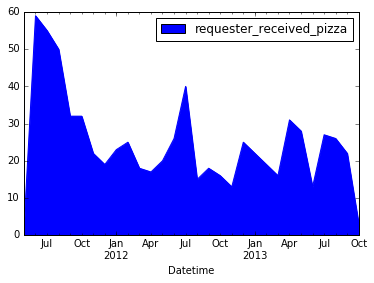

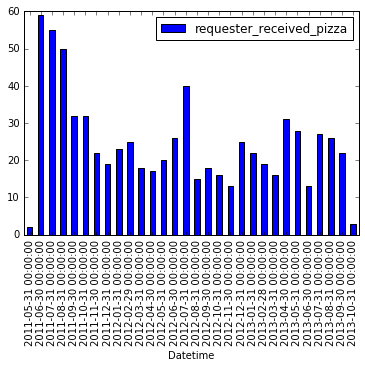

In [13]:
%matplotlib inline

# plot pizzas by month 
unix_index_base = unix_index.drop(['Hour'], axis=1)
month_pizzas = unix_index_base.resample('M').sum()
month_pizzas_area = month_pizzas.plot(kind='area')


month_pizzas_bar = month_pizzas.plot(kind='bar')

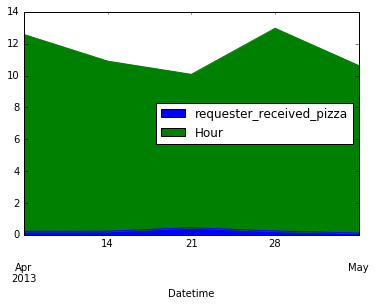

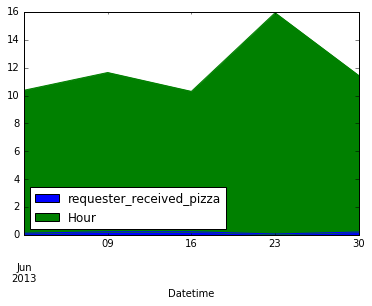

In [14]:
# Analyze pattern by days/weeks

# Take a look at the highest frequency months (07/31/2012 and 4/30/2013)
July2012 = unix_index['7/2012'].resample('D').mean()
# July2012_area = July2012.plot(kind='area')

April2013 = unix_index['4/2013'].resample('W').mean()
April2013_area = April2013.plot(kind='area')


# Take a look at the lowest frequency months
Nov2012 = unix_index['11/2012'].resample('D').mean()
# Nov2012_area = Nov2012.plot(kind='area')

Jun2013 = unix_index['6/2013'].resample('W').mean()
Jun2013_area = Jun2013.plot(kind='area')


count    24.00000
mean     10.75000
std       8.78858
min       0.00000
25%       3.50000
50%       8.50000
75%      16.00000
max      32.00000
Name: requester_received_pizza, dtype: float64
Hour
0     32.0
1     23.0
2     13.0
3      8.0
4      8.0
5      5.0
6      4.0
7      2.0
8      0.0
9      1.0
10     1.0
11     1.0
12     2.0
13     4.0
14     9.0
15     8.0
16    11.0
17    13.0
18    15.0
19    15.0
20    19.0
21    19.0
22    20.0
23    25.0
Name: requester_received_pizza, dtype: float64
Pizza success by hour of the day


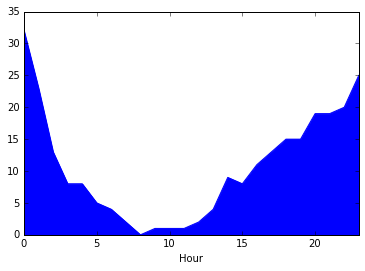

In [15]:
# Analyze pattern by hours

hourly = unix_index['10/2012':'9/2013'].groupby('Hour')['requester_received_pizza'].sum()
print(hourly.describe())
print(hourly)
print("Pizza success by hour of the day")
hourly.plot('area')

# Section 2. Simple Feature Selection and Pre-Processing

In [16]:
# Simple Pre-Processing

def data_preprocessor(s):
    """
    Note: this function pre-processors data:
    (1) removes non-alpha characters
    (2) converts digits to 'number'
    (3) regularizes spaces (although CountVectorizer ignores this unless they are part of words)
    (4) reduces word size to n
    """

    s = [re.sub(r'[?|$|.|!|@|\n|(|)|<|>|_|-|,|\']',r' ',s) for s in s] # strip out non-alpha numeric char, replace with space
    s = [re.sub(r'\d+',r'number ',s) for s in s] # convert digits to number
    s = [re.sub(r' +',r' ',s) for s in s] # convert multiple spaces to single space
    
    # This sets word size to n=5
    num = 5
    def set_word(s):
        temp = []
        for s in s:
            x = s.split()
            z = [elem[:num] for elem in x]
            z = ' '.join(z)
            temp.append(z)       
        return temp
    
    s = set_word(s)
    
    return s



In [17]:
# Set up the data with CountVectorizer

#vectorizer = CountVectorizer(lowercase=True, strip_accents='unicode',stop_words='english')

vectorizer = CountVectorizer(min_df=1,lowercase=True)
tVector = vectorizer.fit_transform(trainCorpus)
dVector = vectorizer.transform(devCorpus)

print ('\nRaw data:')
print ("The size of the vocabulary for the training text data is", tVector.shape[1])
print ("First 5 feature Names:", vectorizer.get_feature_names()[1:6], "\n")

tVector_p = vectorizer.fit_transform(data_preprocessor(trainCorpus))
dVector_p = vectorizer.transform(data_preprocessor(devCorpus))

print ('\nPre-Processed data:')
print ("The size of the vocabulary for the training text data is", tVector_p.shape[1])
print ("First 5 feature Names:", vectorizer.get_feature_names()[1:6], "\n")


Raw data:
The size of the vocabulary for the training text data is 17213
First 5 feature Names: ['000', '0000', '0011011001111000', '00243364', '00pm'] 


Pre-Processed data:
The size of the vocabulary for the training text data is 10491
First 5 feature Names: ['aaaaa', 'aan', 'ab', 'aback', 'aband'] 



# Section 3. Baseline Models

In [18]:
# Group scoring functions

def roc_curve1(y_true, y_pred_prob):
    """This function plots the ROC curve
    Inputs: y_true, correct label
            y_pred_prob, predicted probabilities
    """
    fpr, tpr, thr = roc_curve(y_true, y_pred_prob)
   
    plt.figure()
    plt.plot(fpr,tpr)
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.title("ROC Curve")
    plt.show()
    

def score_rep(y_true, y_pred, desc):
    """Function to print out comprehensive report for classification test
    Inputs: y_true, correct label
            y_pred, predicted label from model
            desc, description of model
    Output: classification report
    """
    print(desc)
    print("-"*75)
    print("Accuracy: ", metrics.accuracy_score(y_true, y_pred))
    print("Area under curve of ROC: ", metrics.roc_auc_score(y_true, y_pred))
    print("Classification report:\n")
    print(metrics.classification_report(y_true, y_pred))
    print("-"*75)

## 3.1 Subreddit Models

## 3.1a Logistic Regression

In [19]:
# Logistic Regression

C = 0.01 #(For now)

modelLogit = LogisticRegression(penalty='l2', C=C)
modelLogit.fit(tVector,trainLabel)
logitScore = round(modelLogit.score(dVector, devLabel), 4)
print("For C = ", C, "Logistic regression accuracy:", logitScore)

modelLogit.fit(tVector_p,trainLabel)
logitScore = round(modelLogit.score(dVector_p, devLabel), 4)
print("For C = ", C, "Logistic regression (processed data) accuracy:", logitScore)


For C =  0.01 Logistic regression accuracy: 0.736
For C =  0.01 Logistic regression (processed data) accuracy: 0.73


## 3.1b Naive Bayes

In [20]:
# Multinomial NB

alpha = 0.01

clf = BernoulliNB(alpha=alpha)
clf.fit(tVector, trainLabel)
test_predicted_labels = clf.predict(dVector) 
print ('Bernoulli NB using raw data with alpha = %1.3f:' %alpha, metrics.accuracy_score(devLabel,test_predicted_labels) )

clf.fit(tVector_p, trainLabel)
test_predicted_labels = clf.predict(dVector_p) 
print ('Bernoulli NB using processed data  with alpha = %1.3f:' %alpha, metrics.accuracy_score(devLabel,test_predicted_labels) )


Bernoulli NB using raw data with alpha = 0.010: 0.719
Bernoulli NB using processed data  with alpha = 0.010: 0.708


## 3.1c Logistic Regression More Feature Selection

In [21]:
# get the best regularization
regStrength = [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 6.0, 10.0]


for c in regStrength:
    modelLogit = LogisticRegression(penalty='l1', C=c)
    modelLogit.fit(tVector_p, trainLabel)
    logitScore = round(modelLogit.score(dVector_p, devLabel), 4)
    print("For C = ", c, "Logistic regression accuracy:", logitScore)

# although the best score comes from c=.001, the bet F1-score 
# comes from c=.5, and this gives better weight options
modelLogit = LogisticRegression(penalty='l1', C=.5, tol = .1)
modelLogit.fit(tVector_p, trainLabel)

print(max(modelLogit.coef_[0]))
numWeights = 5

sortIndex = np.argsort(modelLogit.coef_)
iLen = len(sortIndex[0])
print("\nTop", numWeights, "Weighted Features:")

for index in range((iLen - numWeights) , iLen):
    lookup = sortIndex[0][index]
    print(lookup)
    weight =  modelLogit.coef_[0][lookup]
    print(vectorizer.get_feature_names()[sortIndex[0][index]], weight)

For C =  0.0001 Logistic regression accuracy: 0.74
For C =  0.001 Logistic regression accuracy: 0.74
For C =  0.01 Logistic regression accuracy: 0.74
For C =  0.1 Logistic regression accuracy: 0.734
For C =  0.5 Logistic regression accuracy: 0.673
For C =  1.0 Logistic regression accuracy: 0.654
For C =  2.0 Logistic regression accuracy: 0.653
For C =  6.0 Logistic regression accuracy: 0.645
For C =  10.0 Logistic regression accuracy: 0.646
0.85431103496

Top 5 Weighted Features:
6543
orang 0.720134041926
621
babie 0.732300523521
10070
weds 0.8308238781
740
batte 0.837145386732
4292
hurti 0.85431103496


## 3.2 LR models for Status/Time features

## 3.2a LR model for Status Only

In [22]:
# LOGISTIC REGRESSION MODELS
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l2')

# create training labels for pizza success
train_labels = np.asarray(allTData['requester_received_pizza'])
dev_labels = np.asarray(allDData['requester_received_pizza'])

# Z-scored for Request-Retrieval Z-score
diff_combined = np.asarray(statusTtrain[['Request-Retrieval Z-score']].copy())
diff_dev_combined = np.asarray(statusDtrain[['Request-Retrieval Z-score']].copy())
train_combine_model = lr.fit(diff_combined, train_labels)
dev_combine_labels = train_combine_model.predict(diff_dev_combined)
combine_score = train_combine_model.score(diff_dev_combined, dev_labels)
combine_F1score = metrics.f1_score(dev_combine_labels, dev_labels)

# Z-scores for Request, Retrieval, and Request-Retrieval Z-scores and Flair
zcomb_train = statusTtrain[['Request Z-score','Retrieval Z-score','Request-Retrieval Z-score', 'requester_user_flair']]
zcomb_train['requester_user_flair'] = zcomb_train['requester_user_flair'].apply(flair_numeric).fillna(0)

zcomb_dev = statusDtrain[['Request Z-score','Retrieval Z-score','Request-Retrieval Z-score', 'requester_user_flair']]
zcomb_dev['requester_user_flair'] = zcomb_dev['requester_user_flair'].apply(flair_numeric).fillna(0)

zcomb_model = lr.fit(zcomb_train, train_labels)
zcomb_labels = zcomb_model.predict(zcomb_dev)
zcomb_score = zcomb_model.score(zcomb_dev, dev_labels)
zcomb_F1score = metrics.f1_score(zcomb_labels, dev_labels)

# Z-scores for Request, Retrieval, and Request-Retrieval Z-scores
z_status_train = statusTtrain[['Request Z-score','Retrieval Z-score','Request-Retrieval Z-score']]
z_status_dev = statusDtrain[['Request Z-score','Retrieval Z-score','Request-Retrieval Z-score']]

z_status_model = lr.fit(z_status_train, train_labels)
z_status_labels = z_status_model.predict(z_status_dev)
z_status_score = z_status_model.score(z_status_dev, dev_labels)
z_status_F1score = metrics.f1_score(z_status_labels, dev_labels)

                       
print("\nFor model with Request-Retrieval Z-Score only:")
print("Accuracy:", combine_score)
print("F1 score:", combine_F1score)

print("\nZ-scores for Request, Retrieval, Request-Retrieval Z-Score and Flair:")
print("Accuracy:", zcomb_score)
print("F1 score:", zcomb_F1score)
                        
print("\nZ-scores for Request, Retrieval, Request-Retrieval Z-Score:")
print("Accuracy:", z_status_score)
print("F1 score:", z_status_F1score)


For model with Request-Retrieval Z-Score only:
Accuracy: 0.738
F1 score: 0.0

Z-scores for Request, Retrieval, Request-Retrieval Z-Score and Flair:
Accuracy: 1.0
F1 score: 1.0

Z-scores for Request, Retrieval, Request-Retrieval Z-Score:
Accuracy: 0.737
F1 score: 0.0


/Users/Jen2/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Jen2/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## 3.2b LR model for Status + Hour


Scoring for Request-retrieval Z-scores and Hour
Accuracy: 0.74
F1 score: 0.0


/Users/Jen2/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


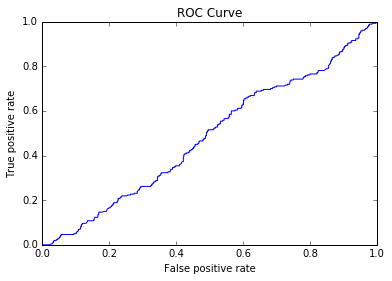

Logistic Regression, C = 0.01
---------------------------------------------------------------------------
Accuracy:  0.74
Area under curve of ROC:  0.5
Classification report:

             precision    recall  f1-score   support

      False       0.74      1.00      0.85       740
       True       0.00      0.00      0.00       260

avg / total       0.55      0.74      0.63      1000

---------------------------------------------------------------------------


/Users/Jen2/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [23]:
# FOR STATUS AND TIME BY HOUR
lr = LogisticRegression(penalty='l2', C=0.01)

train_labels = np.asarray(allTData['requester_received_pizza'])
dev_labels = np.asarray(allDData['requester_received_pizza'])

# setup training and development datasets
# train
stathourTData = pandas.concat([statusTtrain['Request-Retrieval Z-score'], allTData['unix_timestamp_of_request_utc']], axis=1, 
                              keys=['Request-Retrieval Z-score', 'unix_timestamp_of_request_utc'])
stathourTData['Datetime'] = pandas.to_datetime(stathourTData['unix_timestamp_of_request_utc'], unit='s')
stathourTData['Hour'] = stathourTData['Datetime'].dt.hour
stathourTData = stathourTData.drop(['Datetime', 'unix_timestamp_of_request_utc'], axis=1)
# display(stathourTData.head(5))

# development
stathourDData = pandas.concat([statusDtrain['Request-Retrieval Z-score'], allDData['unix_timestamp_of_request_utc']], axis=1, 
                              keys=['Request-Retrieval Z-score', 'unix_timestamp_of_request_utc'])
stathourDData['Datetime'] = pandas.to_datetime(stathourDData['unix_timestamp_of_request_utc'], unit='s')
stathourDData['Hour'] = stathourDData['Datetime'].dt.hour
stathourDData = stathourDData.drop(['Datetime', 'unix_timestamp_of_request_utc'], axis=1)
# display(stathourDData.head(5))

# fit LR models
train_stathour_model = lr.fit(stathourTData, train_labels)
dev_stathour_labels = train_stathour_model.predict(stathourDData)
stathour_score = train_stathour_model.score(stathourDData, dev_labels)
stathour_F1score = metrics.f1_score(dev_stathour_labels, dev_labels)

print("\nScoring for Request-retrieval Z-scores and Hour")
print("Accuracy:", stathour_score)
print("F1 score:", stathour_F1score)
roc_curve1(dev_labels, train_stathour_model.predict_proba(stathourDData)[:,0])
score_rep(dev_labels, dev_stathour_labels,"Logistic Regression, C = 0.01")

## 3.2c LR model for Status and Bucketed Hour


Scoring for Request-retrieval Z-scores and bucketed Hour:
Accuracy: 0.738
F1 score: 0.0


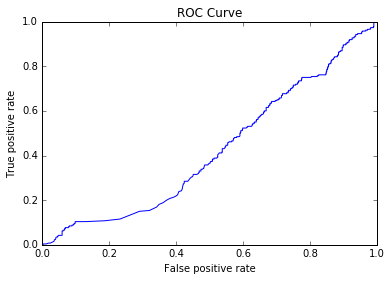

Logistic Regression, C = 0.01
---------------------------------------------------------------------------
Accuracy:  0.738
Area under curve of ROC:  0.498648648649
Classification report:

             precision    recall  f1-score   support

      False       0.74      1.00      0.85       740
       True       0.00      0.00      0.00       260

avg / total       0.55      0.74      0.63      1000

---------------------------------------------------------------------------


In [24]:
# FOR STATUS AND BUCKETED HOUR
lr = LogisticRegression(penalty='l2')

# Bucket hours
def bucket(x):
    if x >= 6 and x <= 13:
        return 0
    if x >= 0 and x <=2:
        return 1
    if x >= 16 and x <=23:
        return 1
    else:
        return 2

bucketTData = stathourTData
bucketTData['Hour'] = bucketTData['Hour'].apply(bucket)
bucketDData = stathourDData
bucketDData['Hour'] = bucketDData['Hour'].apply(bucket)

# fit LR models
train_buckethr_model = lr.fit(bucketTData, train_labels)
dev_buckethr_labels = train_buckethr_model.predict(bucketDData)
buckethr_score = train_buckethr_model.score(bucketDData, dev_labels)
buckethr_F1score = metrics.f1_score(dev_buckethr_labels, dev_labels)

print("\nScoring for Request-retrieval Z-scores and bucketed Hour:")
print("Accuracy:", buckethr_score)
print("F1 score:", buckethr_F1score)
roc_curve1(dev_labels, train_buckethr_model.predict_proba(bucketDData)[:,0])
score_rep(dev_labels, dev_buckethr_labels,"Logistic Regression, C = 0.01")

# Vader Sentiment

In [25]:
#Testing our Vader
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()
test = "It was one of the worst movies I've seen, despite good reviews."

def print_sentiment_scores(sentence):
    snt = analyser.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(snt)))
    print(snt['compound'])

print_sentiment_scores("It was one of the worst movies I've seen, despite good reviews.")

#sentences = "VADER is smart, handsome, and funny."

#print_sentiment_scores(sentences)

sentences = ["VADER is smart, handsome, and funny.", "VADER is silly, ugly, and rude!"]

for sentence in sentences:
    print("\n")
    print(sentence)
    vs = print_sentiment_scores(sentence)


ImportError: No module named 'vaderSentiment'

In [ ]:
# Setting up for Titles
title = allTData[['request_title', 'requester_received_pizza']].copy()
title.columns = ['Title', 'Got Pizza']
print("\n")
print("Titles and Pizza Success\n")
print(title.head(10))
pizza_title = title.groupby(['Got Pizza'])
print("\n")



In [ ]:
titles = allTData['request_title']

for title in titles:
    print("\n")
    print_sentiment_scores(title)
    

In [ ]:
# I think I have the wrong approach here
from sklearn.linear_model import LogisticRegression

def score_rep(y_true, y_pred, desc):
    """Function to print out comprehensive report for classification test
    Inputs: y_true, correct label
            y_pred, predicted label from model
            desc, description of model
    Output: classification report
    """
    print(desc)
    print("-"*75)
    print("Accuracy: ", metrics.accuracy_score(y_true, y_pred))
    print("Area under curve of ROC: ", metrics.roc_auc_score(y_true, y_pred))
    print("Classification report:\n")
    print(metrics.classification_report(y_true, y_pred))
    print("-"*75)
    
C = 100

modelLogit = LogisticRegression(penalty = 'l2', C = C)

trainLabel = allTData['requester_received_pizza']

devLabel = allDData['requester_received_pizza']

snt = analyser.polarity_scores(sentence)

title = snt['compound']

modelLogit.fit(tVector,trainLabel)
score_rep(devLabel,modelLogit.predict(dVector),'Logistic Regression, C = 0.001')

modelLogit.fit(got_pizza,trainLabel)
score_rep(devLabel,modelLogit.predict(dVector_p),'Logistic Regression, C = 0.001')


In [ ]:
# Setting up for Body Copy
title = allTData[['request_text', 'requester_received_pizza']].copy()
title.columns = ['Text', 'Got Pizza']
print("\n")
print("Text and Pizza Success\n")
print(title.head(10))
pizza_title = title.groupby(['Got Pizza'])
print("\n")

In [ ]:
text = allTData['request_text']

for copy in text:
    print("\n")
    print_sentiment_scores(copy)
    